In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import seml
import seaborn as sns
from poisson_atac.utils import model_type_map
import itertools
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np

Global seed set to 0


In [3]:
from poisson_atac.utils import load_experiment

In [4]:
from statannotations.Annotator import Annotator
import itertools

In [5]:
fig_path = 'panels/Figure2/'

In [6]:
dataset_map = {'neurips': 'Neurips\nall batches', 'hematopoiesis': 'Satpathy\net al.'}

# Useful functions

In [7]:
def load_seml(seml_database):
    results = seml.get_results(seml_database, to_data_frame=True,  fields=["config", "config_hash", "result", "batch_id"])

    results['config.data.dataset'] = results['config.data.dataset'].map(dataset_map)
    results['config.setup.model_params.use_observed_lib_size'] = results['config.setup.model_params.use_observed_lib_size'].map({True: "True", False: "False", np.nan: ''})
    results['config.model.model_type'] = results['config.model.model_type'] + results['config.setup.model_params.use_observed_lib_size'].astype(str) 
    results["config.model.model_type"] = results["config.model.model_type"].map(model_type_map)

    return results

In [8]:
def create_annotated_boxplot(data, pairs, x, y, hue, hue_order, order, test, ax, x_label=None, y_label=None, legend=True, y_lim=None):
    sns.boxplot(data = data, x=x, y=y, hue=hue, hue_order = hue_order, order=order, orient="v", ax=ax)
    if test:
        annot = Annotator(ax, pairs, data=data, x=x, y=y, order=order, hue=hue, hue_order=hue_order, orient="v")
        annot.configure(test=test, text_format='star', loc='inside', comparisons_correction="Benjamini-Hochberg", verbose=2)
        annot.apply_test()
        ax, test_results = annot.annotate()
    
        
    if x_label:
        plt.xlabel(x_label)
    else:
        plt.xlabel("")
        
    if y_label:
        plt.ylabel(y_label)
    else:
        plt.ylabel("")
        ax.axes.get_yaxis().set_ticklabels([])
        
    if y_lim:
        plt.ylim(y_lim)
        
    if legend:
        plt.legend()
    else:
        ax.axes.get_legend().set_visible(False)
        
    plt.tight_layout()
    return ax

In [9]:
def plot_metrics_per_dataset(data, datasets, x, y, hue, hue_order, y_label, save_path, figsize, test='t-test_paired'):
    pairs_prelim = [list(itertools.product([dataset], model_order)) for dataset in datasets]
    pairs = [list(itertools.combinations(dataset, 2)) for dataset in pairs_prelim]
    pairs = list(itertools.chain(*pairs))
    
    fig, ax = plt.subplots(figsize=figsize)
    ax = create_annotated_boxplot(data = data, pairs=pairs, y=y, x=x, hue=hue, order=None, hue_order=hue_order, ax=ax, test=test, y_label=y_label)
    if save_path:
        fig.savefig(os.path.join(fig_path, f'{y.split(".")[-1]}_{"_".join(hue_order)}.pdf'))
        fig.savefig(os.path.join(fig_path, f'{y.split(".")[-1]}_{"_".join(hue_order)}.png'))

# Reconstruction metrics

## Load experiments

In [10]:
seml_database = 'atac_to_atac'

In [11]:
results = load_seml(seml_database)

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

In [12]:
df = results[results["config.data.batch"].isna()] #filtering for test data (final run)

In [13]:
df.groupby(['config.data.dataset', 'config.model.model_type', 'config.setup.model_params.n_latent']).size() # check that all have the same number of runs

config.data.dataset   config.model.model_type  config.setup.model_params.n_latent
Neurips\nall batches  Binary VAE               60                                    5
                      PeakVI                   80                                    5
                      Poisson VAE              100                                   5
Satpathy\net al.      Binary VAE               100                                   5
                      PeakVI                   70                                    5
                      Poisson VAE              100                                   5
dtype: int64

# Plot embeddings

In [14]:
import scanpy as sc
#sc.settings.figdir = fig_path

In [15]:
sc.set_figure_params(scanpy=True, dpi=80, dpi_save=250,
                     frameon=False,
                      color_map="YlGnBu_r",format='pdf', transparent=False, #YlGnBu_r
                    ipython_format='png2x', figsize=(8,8))

/home/icb/laura.martens/miniconda3/envs/poisson_atac_new/lib/python3.9/site-packages/scanpy/_settings.py:447: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)


In [16]:
from poisson_atac.utils import load_experiment, compute_embedding

In [17]:
#import get_experiment function from seml run
from poisson_atac.experiments.atac_to_atac.experiment_runner import get_experiment

## Determine best embeddings based on average_precision

In [18]:
best = df.sort_values('result.average_precision', ascending=False).groupby(['config.data.dataset', 'config.model.model_type']).first()

In [19]:
best

_id  batch_id  \
config.data.dataset  config.model.model_type                  
Neurips\nall batches Binary VAE                67         3   
                     PeakVI                    62         3   
                     Poisson VAE               52         3   
Satpathy\net al.     Binary VAE               151         7   
                     PeakVI                   146         7   
                     Poisson VAE               70         3   

                                                                   config_hash  \
config.data.dataset  config.model.model_type                                     
Neurips\nall batches Binary VAE               a5f0eb37a267cd1147021ae89f6de2fa   
                     PeakVI                   b3feda37c38d60b1e99b4c279240ba2e   
                     Poisson VAE              f956cc1e4780c256e437a37c8bc1935c   
Satpathy\net al.     Binary VAE               1e7d434cfe8f33baf580c4b2a8e44660   
                     PeakVI                   094eab89c2905f303c3e0be006504ed1   
                     Poisson VAE              aa9577e0cd388aae56767ab1dda11dc6   

                                              config.overwrite  \
config.data.dataset  config.model.model_type                     
Neurips\nall batches Binary VAE                             67   
                     PeakVI                                 62   
                     Poisson VAE                            52   
Satpathy\net al.     Binary VAE                            151   
                     PeakVI                                146   
                     Poisson VAE                            70   

                                             config.db_collection  \
config.data.dataset  config.model.model_type                        
Neurips\nall batches Binary VAE                      atac_to_atac   
                     PeakVI                          atac_to_atac   
                     Poisson VAE                     atac_to_atac   
Satpathy\net al.     Binary VAE                      atac_to_atac   
                     PeakVI                          atac_to_atac   
                     Poisson VAE                     atac_to_atac   

                                             config.data.batch  \
config.data.dataset  config.model.model_type                     
Neurips\nall batches Binary VAE                           None   
                     PeakVI                               None   
                     Poisson VAE                          None   
Satpathy\net al.     Binary VAE                           None   
                     PeakVI                               None   
                     Poisson VAE                          None   

                                              config.optimization.regularization.learning_rate  \
config.data.dataset  config.model.model_type                                                     
Neurips\nall batches Binary VAE                                                         0.0001   
                     PeakVI                                                             0.0001   
                     Poisson VAE                                                        0.0001   
Satpathy\net al.     Binary VAE                                                         0.0001   
                     PeakVI                                                             0.0001   
                     Poisson VAE                                                        0.0001   

                                              config.optimization.regularization.weight_decay  \
config.data.dataset  config.model.model_type                                                    
Neurips\nall batches Binary VAE                                                         0.001   
                     PeakVI                                                             0.001   
                     Poisson VAE                                                        0.001   
Sat

## NeurIPS dataset

### PeakVI model

In [20]:
model_hash=best.loc[(dataset_map['neurips'], model_type_map["peakvi"]), "config_hash"]

In [21]:
model_hash

'b3feda37c38d60b1e99b4c279240ba2e'

In [23]:
ex, model, config = load_experiment(seml_database, model_hash, get_experiment)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

get_experiment


2022-07-26 11:29:40 (INFO): Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
2022-07-26 11:29:40 (INFO): Unable to initialize backend 'gpu': NOT_FOUND: Could not find registered platform with name: "cuda". Available platform names are: Host Interpreter
2022-07-26 11:29:40 (INFO): Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.


PEAKVAE(
  (z_encoder): Encoder(
    (encoder): FCLayers(
      (fc_layers): Sequential(
        (Layer 0): Sequential(
          (0): Linear(in_features=116490, out_features=341, bias=True)
          (1): None
          (2): LayerNorm((341,), eps=1e-05, elementwise_affine=False)
          (3): LeakyReLU(negative_slope=0.01)
          (4): Dropout(p=0.1, inplace=False)
        )
        (Layer 1): Sequential(
          (0): Linear(in_features=341, out_features=341, bias=True)
          (1): None
          (2): LayerNorm((341,), eps=1e-05, elementwise_affine=False)
          (3): LeakyReLU(negative_slope=0.01)
          (4): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (mean_encoder): Linear(in_features=341, out_features=80, bias=True)
    (var_encoder): Linear(in_features=341, out_features=80, bias=True)
  )
  (z_decoder): Decoder(
    (px_decoder): FCLayers(
      (fc_layers): Sequential(
        (Layer 0): Sequential(
          (0): Linear(in_features=93, out_features=34

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
X_emb = model.get_latent_representation(ex.adata)
compute_embedding(ex.adata, X_emb)

In [ ]:
sc.pl.umap(ex.adata, color="cell_type", save="peakvi.png")

In [ ]:
sc.pl.umap(ex.adata, color="batch", save="peakvi_batch.png")

### Poisson VAE model, observed seq. coverage

In [24]:
model_hash=best.loc[(dataset_map['neurips'], model_type_map["poissonviTrue"]), "config_hash"]

In [25]:
model_hash

'f956cc1e4780c256e437a37c8bc1935c'

In [26]:
ex, model, config = load_experiment(seml_database, model_hash, get_experiment)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

get_experiment
PoissonVAE(
  (z_encoder): Encoder(
    (encoder): FCLayers(
      (fc_layers): Sequential(
        (Layer 0): Sequential(
          (0): Linear(in_features=116490, out_features=341, bias=True)
          (1): None
          (2): LayerNorm((341,), eps=1e-05, elementwise_affine=False)
          (3): LeakyReLU(negative_slope=0.01)
          (4): Dropout(p=0.1, inplace=False)
        )
        (Layer 1): Sequential(
          (0): Linear(in_features=341, out_features=341, bias=True)
          (1): None
          (2): LayerNorm((341,), eps=1e-05, elementwise_affine=False)
          (3): LeakyReLU(negative_slope=0.01)
          (4): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (mean_encoder): Linear(in_features=341, out_features=100, bias=True)
    (var_encoder): Linear(in_features=341, out_features=100, bias=True)
  )
  (l_encoder): Encoder(
    (encoder): FCLayers(
      (fc_layers): Sequential(
        (Layer 0): Sequential(
          (0): Linear(in_features=11

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

RuntimeError: Error(s) in loading state_dict for PoissonVAE:
	Missing key(s) in state_dict: "region_factors", "decoder.y_decoder.fc_layers.Layer 0.0.weight", "decoder.y_decoder.fc_layers.Layer 0.0.bias", "decoder.y_decoder.fc_layers.Layer 1.0.weight", "decoder.y_decoder.fc_layers.Layer 1.0.bias", "decoder.y_scale_decoder.0.weight", "decoder.y_scale_decoder.0.bias". 
	Unexpected key(s) in state_dict: "decoder.px_decoder.fc_layers.Layer 0.0.weight", "decoder.px_decoder.fc_layers.Layer 0.0.bias", "decoder.px_decoder.fc_layers.Layer 1.0.weight", "decoder.px_decoder.fc_layers.Layer 1.0.bias", "decoder.px_scale_decoder.0.weight", "decoder.px_scale_decoder.0.bias". 

In [193]:
X_emb = model.get_latent_representation(ex.adata)
compute_embedding(ex.adata, X_emb)

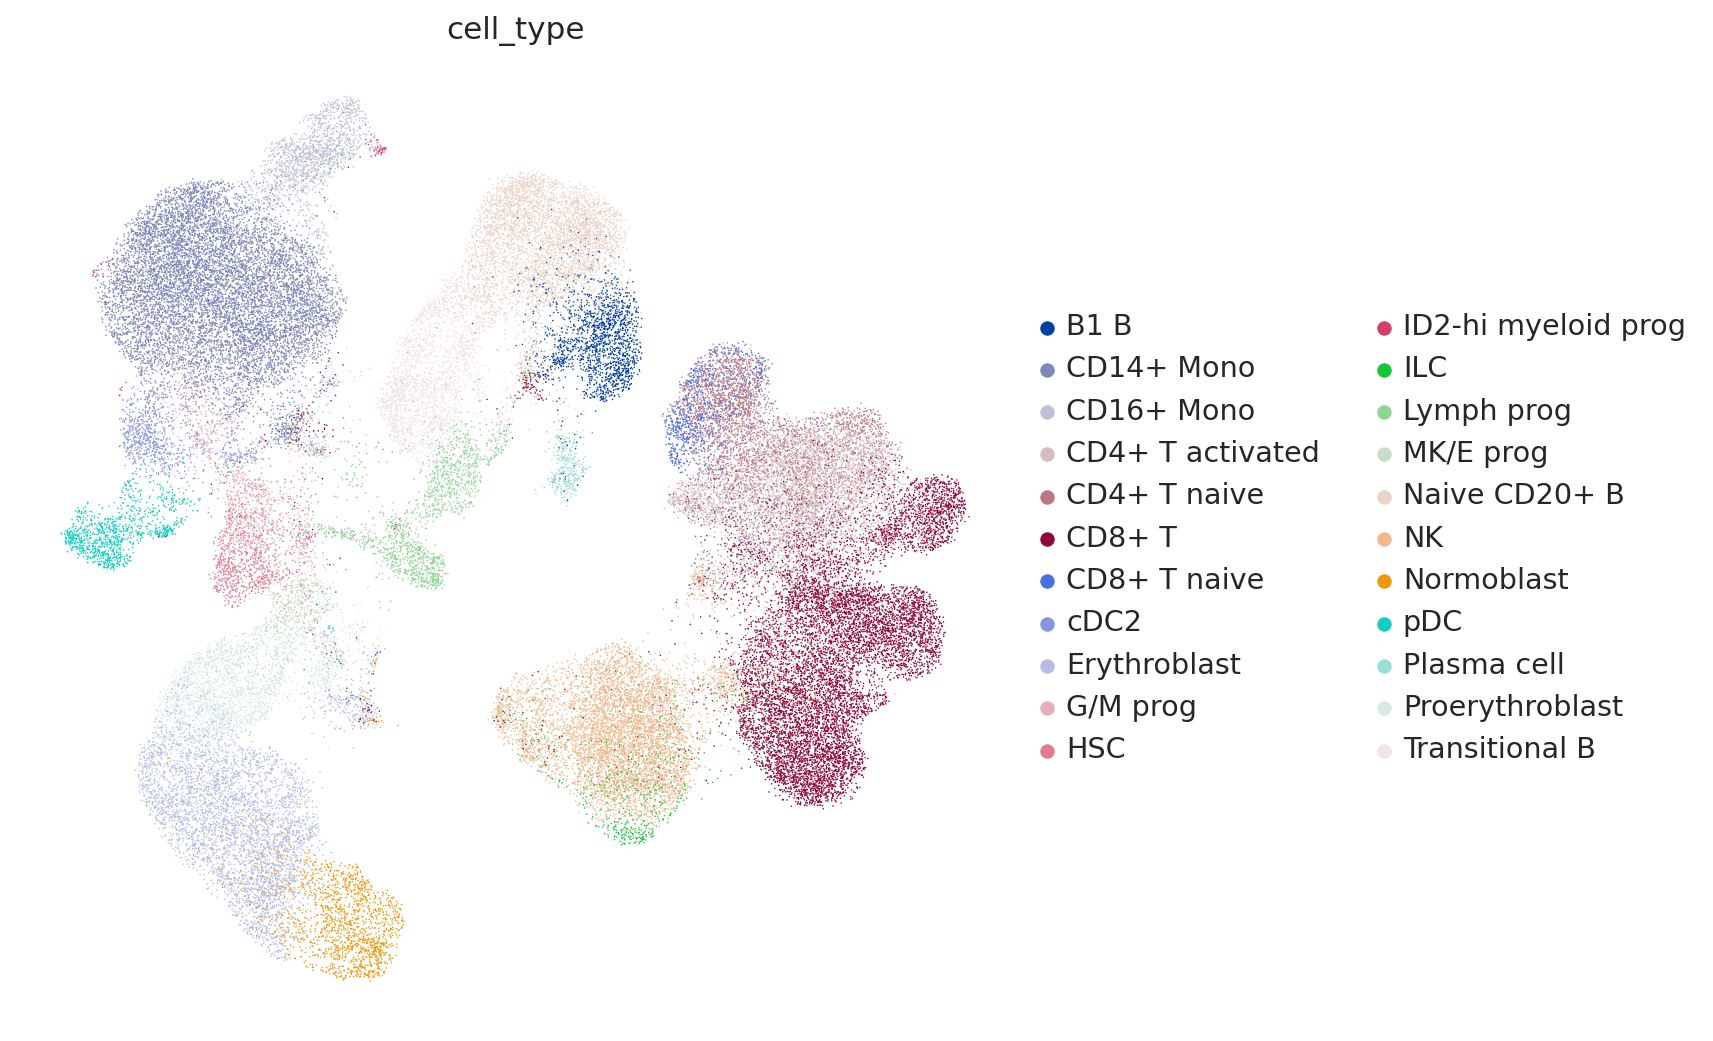

In [194]:
sc.pl.umap(ex.adata, color="cell_type", save='poissonviTrue.png')

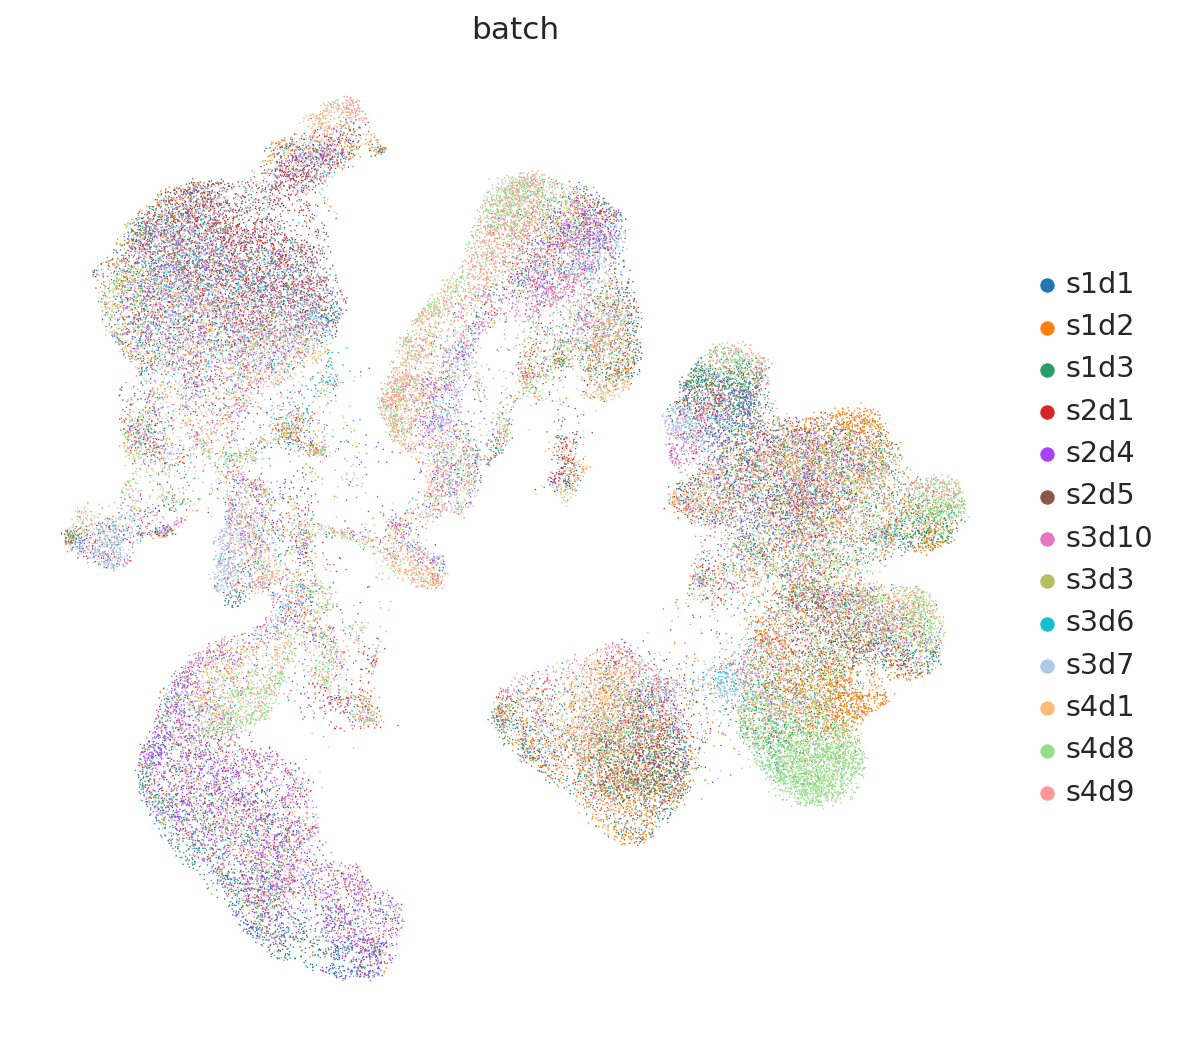

In [195]:
sc.pl.umap(ex.adata, color="batch", save='poissonviTrue_batch.png')